# <span style="color:blue">Workshop 5: Rule-Based GP in DEAP</span>

Simon O'Keefe: simon.okeefe@york.ac.uk

Danny Roberts: danny.roberts@york.ac.uk

Tianda Sun: tianda.sun@york.ac.uk

# <span style="color:#0073e6">Topics</span>

- Introduction to solving rule-based problems with GP, including an intricate system of functions and resources 
- Implementing a loosely-typed GP to solve the classic Santa Fe Ant Trail problem
- Dealing with bloat

# <span style="color:#0073e6">Learning Objectives</span>

- Learn how to program a GP to produce rule-based AI
- Understand and deal with bloat

# <span style="color:Blue">Exercise: Santa Fe Ant Trail Problem</span>

# <span style="color:#0073e6">Context</span>

The artificial ant problem (or Santa Fe Ant Problem) is a well-studied problem with a simple fitness function. The problem is to devise an agent that can successfully navigate an artificial ant along a trail on a square grid to collect as much food as possible within a maximum number of moves (here 600). You can see a visualization of the problem here: 
https://www.youtube.com/watch?v=BKF7pGw8qbY

# <span style="color:#0073e6">Map Setup</span>

Make sure that you have the file santafe_trail.txt in the same folder as the notebook. This text file includes the map for the ants to solve. Open the map in a text editor. You can see that empty cells are represented with periods and food is represented with a hash. There is only one map to work with here, but you can create your own varitions of this in your text editor.

# <span style="color:#0073e6">The Ant Class</span>

In the code, an ant will follow the instructions provided to it from an individual (an evolved decision tree) evolved by GP. So there is a single ant agent that is used to evaluate your individuals, but a population of individuals that use the ant for evaluation.  A basic way to evaluate fitness is simply looking at how much a particular ant has eaten (ant.eaten), which is implemented here.

An ant can navigate based on three operations:
- Move_Forward	- Move the ant forward one square
- Turn_Right		- Turn the ant to the right 90 degrees
- Turn_Left		- Turn the ant to the left 90 degrees.

These three commands therefore part of the terminal set in a GP. Each of these operations is assumed to take one time unit to execute.

The sensing function if_food_ahead looks into the square the ant is currently facing and then executes one of its two arguments depending upon whether that square contains food or is empty. Two other functions, Prog2 and Prog3, are provided. These take two and three arguments respectively which are executed in sequence. These three functions are therefore also part of the primitive set.

# <span style="color:Blue">Exercise 1: Implement the GP</span>

1. Go through the code below and try to understand what it the ant is doing and how the problem works.
2. Code the genetic programming algorithm to find a solution (as in previous examples).
3. The best solution in terms of number of food items eaten is 89 for this problem. Can you improve the performance of your algorithm? Be sure to also output your final best solution as tree for examination.

# <span style="color:#0073e6">Ant Code</span>

In [1]:
import copy
import random
import numpy
import pygraphviz as pgv
from functools import partial

from deap import base
from deap import creator
from deap import tools
from deap import gp

In [2]:
class AntSimulator(object):
    direction = ["north","east","south","west"]
    dir_row = [1, 0, -1, 0]
    dir_col = [0, 1, 0, -1]
    
    def __init__(self, max_moves):
        self.max_moves = max_moves
        self.moves = 0
        self.eaten = 0
        self.routine = None
        
    def _reset(self):
        self.row = self.row_start 
        self.col = self.col_start 
        self.dir = 1
        self.moves = 0  
        self.eaten = 0
        self.matrix_exc = copy.deepcopy(self.matrix)

    @property
    def position(self):
        return (self.row, self.col, self.direction[self.dir])
            
    def turn_left(self): 
        if self.moves < self.max_moves:
            self.moves += 1
            self.dir = (self.dir - 1) % 4

    def turn_right(self):
        if self.moves < self.max_moves:
            self.moves += 1    
            self.dir = (self.dir + 1) % 4
        
    def move_forward(self):
        if self.moves < self.max_moves:
            self.moves += 1
            self.row = (self.row + self.dir_row[self.dir]) % self.matrix_row
            self.col = (self.col + self.dir_col[self.dir]) % self.matrix_col
            if self.matrix_exc[self.row][self.col] == "food":
                self.eaten += 1
            self.matrix_exc[self.row][self.col] = "passed"

    def sense_food(self):
        ahead_row = (self.row + self.dir_row[self.dir]) % self.matrix_row
        ahead_col = (self.col + self.dir_col[self.dir]) % self.matrix_col        
        return self.matrix_exc[ahead_row][ahead_col] == "food"
   
    def if_food_ahead(self, out1, out2):
        return partial(if_then_else, self.sense_food, out1, out2)
   
    def run(self,routine):
        self._reset()
        while self.moves < self.max_moves:
            routine()
    
    def parse_matrix(self, matrix):
        self.matrix = list()
        for i, line in enumerate(matrix):
            self.matrix.append(list())
            for j, col in enumerate(line):
                if col == "#":
                    self.matrix[-1].append("food")
                elif col == ".":
                    self.matrix[-1].append("empty")
                elif col == "S":
                    self.matrix[-1].append("empty")
                    self.row_start = self.row = i
                    self.col_start = self.col = j
                    self.dir = 1
        self.matrix_row = len(self.matrix)
        self.matrix_col = len(self.matrix[0])
        self.matrix_exc = copy.deepcopy(self.matrix)

In [3]:
ant = AntSimulator(600)

with  open("santafe_trail.txt") as trail_file:
    ant.parse_matrix(trail_file)

# <span style="color:Blue">You need to decide on your GP below</span>

We now need to define our primitive set. I see a lot of mistakes when defining the "Main" function here. That is because the ant uses information from the environment, and students add these as arguments. However, if you look at the code, the ant object directly accesses the environment, and it is not passed to the evolved function as an argment. As such, we have zero arguments here. However, you could modify the code to pass the arguments, if you liked, and then would need to modify it here.

Don't forget that here you might need to define and register progs (allowing multiple functions to connect together) and your own functions (e.g. if_then_else). No cheating and registering pre-programmed behaviour, though!

Your terminals are the ant behaviour. So for example:
> pset.addTerminal(ant.move_forward)

## <span style="color:#0073e6">Add your primitives and terminals here</span>

In [4]:
pset = gp.PrimitiveSet("MAIN", 0)

In [5]:
def progn(*args):
    for arg in args:
        arg()

def prog2(out1, out2): 
    return partial(progn,out1,out2)

def prog3(out1, out2, out3):     
    return partial(progn,out1,out2,out3)

def if_then_else(condition, out1, out2):
    out1() if condition() else out2()

pset.addPrimitive(ant.if_food_ahead, 2)
pset.addPrimitive(prog2, 2)
pset.addPrimitive(prog3, 3)
pset.addTerminal(ant.move_forward)
pset.addTerminal(ant.turn_left)
pset.addTerminal(ant.turn_right)

## <span style="color:#0073e6">Register your individuals, fitness and operators here</span>

In [6]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

In [7]:
toolbox = base.Toolbox()
toolbox.register("expr_init", gp.genFull, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr_init)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [8]:
#toolbox.register("select", tools.selTournament, tournsize=7)
toolbox.register("select", tools.selDoubleTournament, fitness_size = 7, parsimony_size = 1.4, fitness_first = True, fit_attr='fitness' )
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
# Try parsimony_size = 1.8

## <span style="color:#0073e6">Evaluation functions</span>

In [9]:
#def evalArtificialAntBloatPenalty(individual):
#    routine = gp.compile(individual, pset)
#    ant.run(routine)
#    return ant.eaten - (individual.height)**2.0,

def evalArtificialAnt(individual):
    routine = gp.compile(individual, pset)
    ant.run(routine)
    return ant.eaten,

toolbox.register("evaluate", evalArtificialAnt)

## <span style="color:#0073e6">Register some stats</span>

In [10]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
stats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

## <span style="color:#0073e6">Main body</span>

In [11]:
logbook = tools.Logbook()
pop = toolbox.population(n=500) #

NGEN, CXPB, MUTPB = 200, 0.2, 0.2

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

for g in range(NGEN):
    print("-- Generation %i --" % g)
   
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    Neval = len(invalid_ind)

    pop[:] = offspring
    
    record = stats.compile(pop)

    logbook.record(gen=g, evals=Neval, **record)

    print("-- End of evolution --")

-- Generation 0 --
-- End of evolution --
-- Generation 1 --
-- End of evolution --
-- Generation 2 --
-- End of evolution --
-- Generation 3 --
-- End of evolution --
-- Generation 4 --
-- End of evolution --
-- Generation 5 --
-- End of evolution --
-- Generation 6 --
-- End of evolution --
-- Generation 7 --
-- End of evolution --
-- Generation 8 --
-- End of evolution --
-- Generation 9 --
-- End of evolution --
-- Generation 10 --
-- End of evolution --
-- Generation 11 --
-- End of evolution --
-- Generation 12 --
-- End of evolution --
-- Generation 13 --
-- End of evolution --
-- Generation 14 --
-- End of evolution --
-- Generation 15 --
-- End of evolution --
-- Generation 16 --
-- End of evolution --
-- Generation 17 --
-- End of evolution --
-- Generation 18 --
-- End of evolution --
-- Generation 19 --
-- End of evolution --
-- Generation 20 --
-- End of evolution --
-- Generation 21 --
-- End of evolution --
-- Generation 22 --
-- End of evolution --
-- Generation 23 --
-

-- End of evolution --
-- Generation 191 --
-- End of evolution --
-- Generation 192 --
-- End of evolution --
-- Generation 193 --
-- End of evolution --
-- Generation 194 --
-- End of evolution --
-- Generation 195 --
-- End of evolution --
-- Generation 196 --
-- End of evolution --
-- Generation 197 --
-- End of evolution --
-- Generation 198 --
-- End of evolution --
-- Generation 199 --
-- End of evolution --


## <span style="color:#0073e6">Basic plots</span>

Text(0, 0.5, 'Fitness')

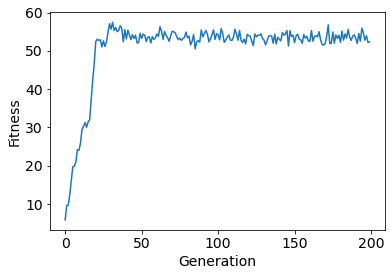

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

gen = logbook.chapters['fitness'].select("gen")
_min = logbook.chapters['fitness'].select("min")
_max = logbook.chapters['fitness'].select("max")
avgs = logbook.chapters['fitness'].select("avg")
stds = logbook.chapters['fitness'].select("std")

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

#line2 = ax1.plot(gen, _min)
#line3 = ax1.plot(gen, _max)

# <span style="color:#0073e6">Examine the best individual</span>

In [13]:
indv = tools.selBest(pop, 1)[0]
print(indv)

if_food_ahead(prog3(prog3(move_forward, move_forward, move_forward), prog3(move_forward, turn_left, move_forward), if_food_ahead(prog2(prog2(turn_left, move_forward), turn_left), turn_right)), prog3(turn_right, move_forward, turn_left))


In [14]:
toolbox.evaluate(indv)

(68,)

In [15]:
nodes, edges, labels = gp.graph(indv)

tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]

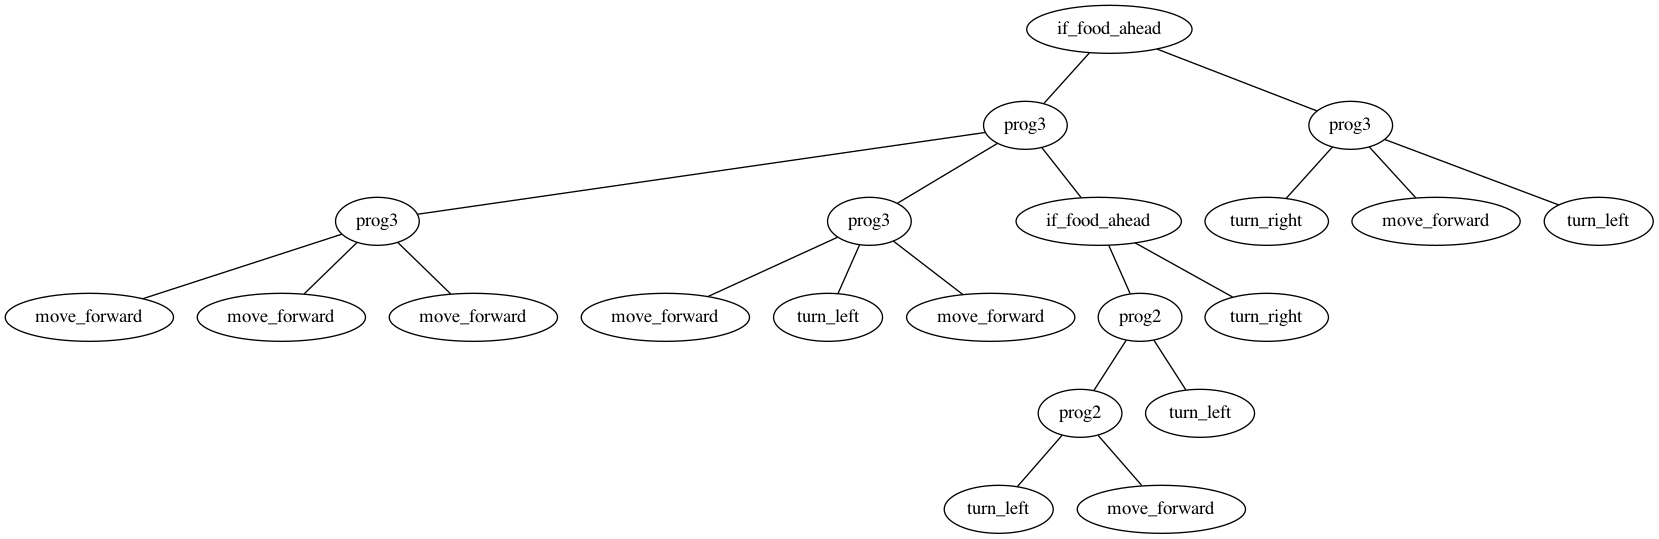

In [16]:
from IPython.display import Image

treePlot = tree.draw(format='png', prog='dot')
Image(treePlot)

# <span style="color:Blue">Exercise 2: Dealing with Bloat</span>

You should see from plotting the tree of the best individual, that there is bloat. Let's examine how to deal with this.

1. Try a crude modification to the evaluation function to add a ‘parsimony penalty’. This is a penality that increases as a function of the height of the tree ( individual.height ).
2. Now remove the bloat penalty. If parsimony penalties like this are not done carefully for some problems, it could give undesirable results. Instead implement a double tournament. Go to the DEAP library reference (https://deap.readthedocs.io/en/master/api/index.html) and look for the selection operator selDoubleTournament(). This will vastly help you to contain bloat in a better manner. Implement this, and play with the parameters a little. Then have a look at the final tree structure compared to before. This is also explained in the lecture.

## <span style="color:Blue">A note on the maximum tree depth in DEAP</span>

Since DEAP uses the Python parser to compile the code represented by the trees, it inherits from its limitations. The most commonly encountered restriction is the parsing stack limit. The Python interpreter parser stack limit is usually fixed between 92 and 99. This means that an expression can at most be composed of 91 succeeding primitives. In other words, a tree can have a maximum depth of 91 in DEAP.